In [64]:
import os
import zipfile
import string
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem.snowball import SnowballStemmer
from scipy.stats import uniform

In [65]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

## Unzip data

In [66]:
INPUT_PATH = 'data/input'
zip_file = 'spooky-author-identification.zip'
os.listdir(INPUT_PATH)

['.ipynb_checkpoints',
 'sample_submission.csv',
 'sample_submission.zip',
 'test.csv',
 'test.zip',
 'train.csv',
 'train.zip']

In [67]:
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(INPUT_PATH)

In [68]:
os.listdir(INPUT_PATH)

['.ipynb_checkpoints',
 'sample_submission.csv',
 'sample_submission.zip',
 'test.csv',
 'test.zip',
 'train.csv',
 'train.zip']

In [69]:
for filename in os.listdir(INPUT_PATH):
    if filename.endswith('.zip'):
        with zipfile.ZipFile(f'{INPUT_PATH}/{filename}', 'r') as zip_ref:
            zip_ref.extractall(INPUT_PATH)
#             os.remove(f'{INPUT_PATH}/{filename}')

In [70]:
os.listdir(INPUT_PATH)

['.ipynb_checkpoints',
 'sample_submission.csv',
 'sample_submission.zip',
 'test.csv',
 'test.zip',
 'train.csv',
 'train.zip']

## Read data

In [71]:
df = pd.read_csv(f'{INPUT_PATH}/train.csv', index_col='id')

In [72]:
df.shape

(19579, 2)

In [73]:
df.head(10)

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL
id22965,"A youth passed in solitude, my best years spen...",MWS
id09674,"The astronomer, perhaps, at this point, took r...",EAP
id13515,The surcingle hung in ribands from my body.,EAP
id19322,I knew that you could not say to yourself 'ste...,EAP


In [74]:
# lowercase
df['processed'] = df['text'].apply(lambda x: x.lower())

In [75]:
# count chars and words
df['n_chars'] = df['processed'].apply(lambda x: len(x))
df['n_words'] = df['processed'].apply(lambda x: len(x.split(' ')))

In [76]:
# count punctuation marks
df['n_punctuation'] = df['processed'].apply(lambda x: len([dig for dig in list(x) if dig in string.punctuation]))

In [77]:
# remove punctuation marks
df['processed'] = df['processed'].apply(lambda x: ''.join(ch for ch in x if ch not in string.punctuation))

In [78]:
df.head()

,text,author,processed,n_chars,n_words,n_punctuation
id,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,231,41,7
id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,71,14,1
id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,200,36,5
id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,206,34,4
id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,174,27,4


In [79]:
# count nouns, adjetives and verbs
nouns = ('NN','NNP','NNPS','NNS')
adjectives = ('JJ','JJR','JJS')
verbs = ('VB','VBD','VBG','VBN','VBP','VBZ')

df['n_noun'] = df['processed'].apply(lambda x: sum(np.in1d(np.array(pos_tag(word_tokenize(x)))[:,1], nouns)))
df['n_adj'] = df['processed'].apply(lambda x: sum(np.in1d(np.array(pos_tag(word_tokenize(x)))[:,1], adjectives)))
df['n_verb'] = df['processed'].apply(lambda x: sum(np.in1d(np.array(pos_tag(word_tokenize(x)))[:,1], verbs)))

In [80]:
# count stopwords
eng_stopwords = set(stopwords.words("english"))
df['n_stopwords'] = df['processed'].apply(lambda x: sum(np.in1d(word_tokenize(x), eng_stopwords)))

In [81]:
# unique words
df['n_unique'] = df['processed'].apply(lambda x: len(set(word_tokenize(x))))

In [82]:
# fractions

for count in ['n_noun', 'n_adj', 'n_verb', 'n_stopwords', 'n_unique']:
    df['fract'+count[1:]] = df[count] / df['n_words']
    
df['fract_punctuation'] = df['n_punctuation']/df['n_chars']

In [83]:
df.head()

,text,author,processed,n_chars,n_words,n_punctuation,n_noun,n_adj,n_verb,n_stopwords,n_unique,fract_noun,fract_adj,fract_verb,fract_stopwords,fract_unique,fract_punctuation
id,,,,,,,,,,,,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,231,41,7,12,2,6,0,35,0.292683,0.048780,0.146341,0.0,0.853659,0.030303
id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,71,14,1,2,1,2,0,14,0.142857,0.071429,0.142857,0.0,1.000000,0.014085
id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,200,36,5,10,5,4,0,32,0.277778,0.138889,0.111111,0.0,0.888889,0.025000
id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,206,34,4,10,6,5,0,31,0.294118,0.176471,0.147059,0.0,0.911765,0.019417
id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,174,27,4,6,1,6,0,25,0.222222,0.037037,0.222222,0.0,0.925926,0.022989


## EDA

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

sns.set(style='whitegrid')

In [85]:
df.columns[df.columns.get_loc('n_chars'):]

Index(['n_chars', 'n_words', 'n_punctuation', 'n_noun', 'n_adj', 'n_verb',
       'n_stopwords', 'n_unique', 'fract_noun', 'fract_adj', 'fract_verb',
       'fract_stopwords', 'fract_unique', 'fract_punctuation'],
      dtype='object')

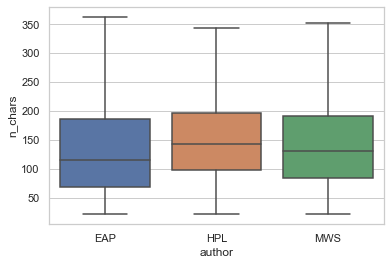

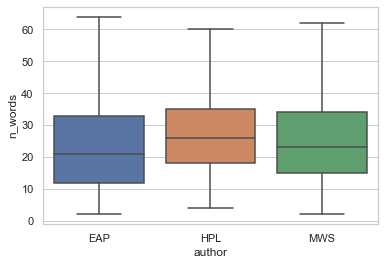

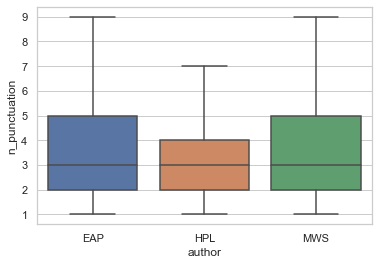

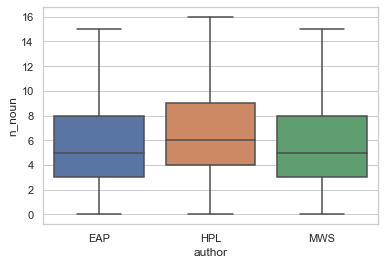

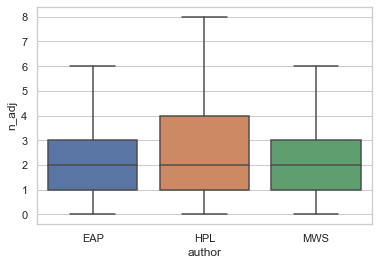

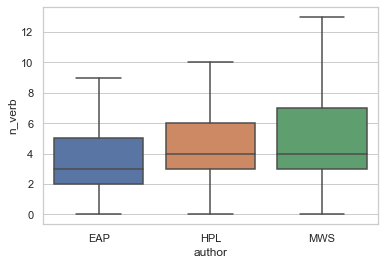

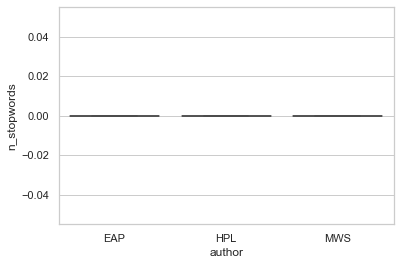

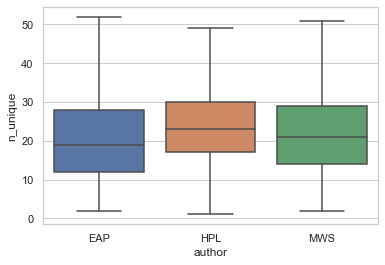

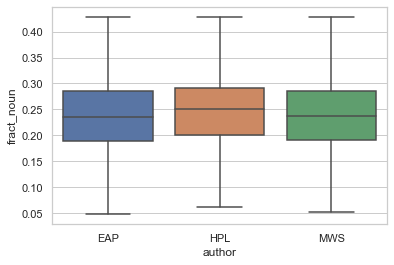

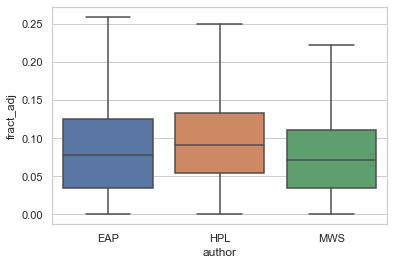

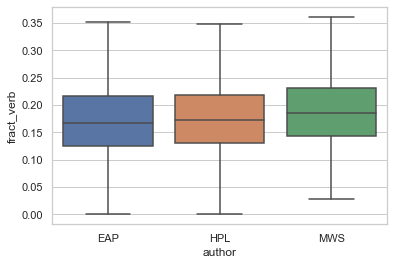

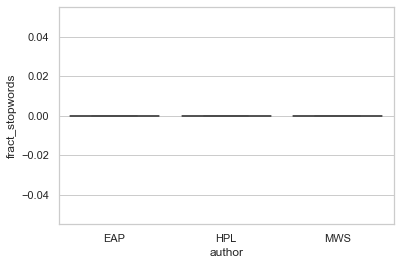

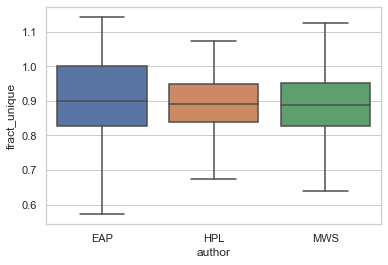

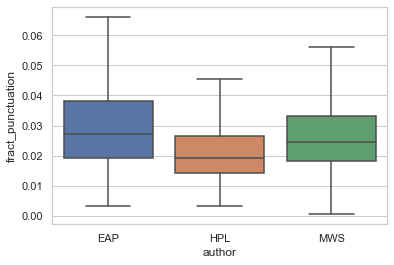

In [86]:
for col in list(df.columns[df.columns.get_loc('n_chars'):]):
    sns.boxplot(x='author', y=col, data=df, showfliers=False)
    plt.show()
    plt.close()

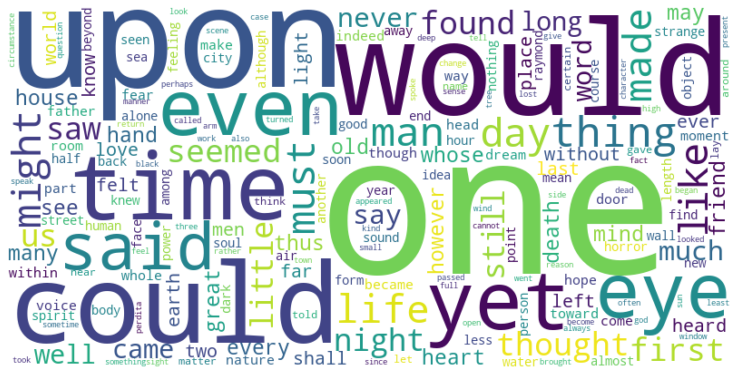

In [94]:
def show_word_cloud(s, author='', save=True):
    text = " ".join(review for review in s)
    # Create stopword list:
    stopwords = set(eng_stopwords)

    # Generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white").generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.figure(figsize=(13, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(author)
    plt.show()
    if save:
#         plt.savefig(f"img/word_cloud{author}.jpg", format="jpg",dpi=100)
        wordcloud.to_file(f"img/word_cloud{author}.png")
    plt.close()
        
show_word_cloud(df['processed'])

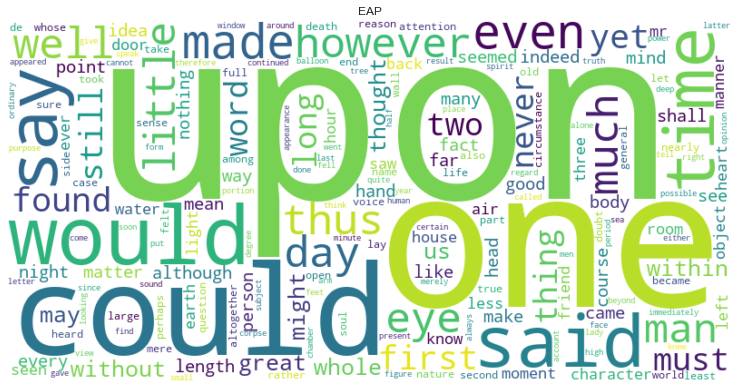

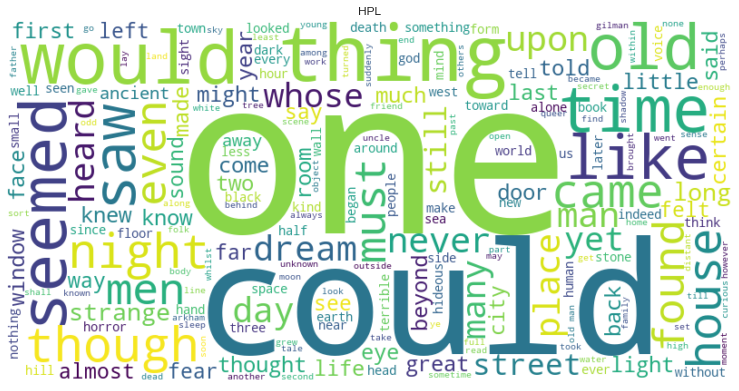

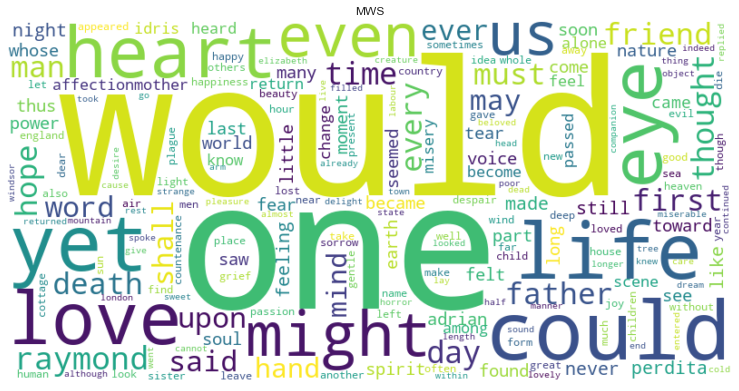

In [95]:
for author in df['author'].unique():
    show_word_cloud(df[df['author'] == author]['processed'], author)

In [21]:
stemmer=SnowballStemmer("english")

def stem(s):
    return ' '.join([stemmer.stem(word) for word in word_tokenize(s)])

%time df['processed'] = df['processed'].apply(lambda x: stem(x))

CPU times: user 5.98 s, sys: 3.47 ms, total: 5.99 s
Wall time: 5.98 s


In [22]:
train_cols = list(df.columns[df.columns.get_loc('processed'):])
X, y = df[train_cols].copy(), df['author'].copy()

In [23]:
# text_pipe = Pipeline([
#     ('tfidf', TfidfVectorizer(stop_words=eng_stopwords)),
# #     ('decompose', TSNE(n_components=2, random_state=42, verbose=False)),
# ])

# %time X = np.concatenate([X, text_pipe.fit_transform(X['processed'])], axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = X_train.copy()
X_test = X_test.copy()

In [25]:
# # text_pipe = TfidfVectorizer(stop_words=eng_stopwords)
# %time text_pipe.fit(X_train['processed'])
# %time X_train = np.concatenate([X_train, text_pipe.transform(X_train['processed'])], axis=1)
# %time X_test = np.concatenate([X_test, text_pipe.transform(X_test['processed'])], axis=1)

In [26]:
tfidf = TfidfVectorizer(stop_words=eng_stopwords, min_df=3)
tfidf.fit(X_train['processed'])
X_train = np.concatenate([X_train, tfidf.transform(X_train['processed']).toarray()], axis=1)
X_test = np.concatenate([X_test, tfidf.transform(X_test['processed']).toarray()], axis=1)

In [27]:
X_train.shape

(13117, 6805)

In [28]:
X_train, X_test = X_train[:, 1:], X_test[:, 1:]

In [29]:
gs = GridSearchCV(
    MultinomialNB(),
    param_grid = { 'alpha':(0.001, 0.01,0.05, 0.1, 0.5, 1, 10)},
    scoring='neg_log_loss',
    n_jobs = 1,
    cv=4,
    verbose=100,
    refit=True
)
gs.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-0.519, total=   1.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-0.511, total=   1.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-0.499, total=   1.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-0.519, total=   1.6s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

GridSearchCV(cv=4, estimator=MultinomialNB(), n_jobs=1,
             param_grid={'alpha': (0.001, 0.01, 0.05, 0.1, 0.5, 1, 10)},
             scoring='neg_log_loss', verbose=100)

In [30]:
nb = gs.best_estimator_
nb

MultinomialNB(alpha=0.05)

In [31]:
accuracy_score(y_test, nb.predict(X_test))

0.8200247601361808

In [32]:
# search_params = {
#     'max_depth': [i for i in range(20, 1000)],
#     'min_samples_split': [i for i in range(2, 20)],
#     'min_samples_leaf': [i for i in range(1, 20)],
#     'max_features': uniform(loc=0.01, scale =0.4),
#     'max_samples': uniform(loc=0.2, scale =0.8)
# #     'max_leaf_nodes': [i for i in range(2, 100)],
# }

# rs = RandomizedSearchCV(
#     RandomForestClassifier(n_estimators = 5, random_state=42, n_jobs=-1),
#     search_params,
#     n_iter=30,
#     scoring='neg_log_loss',
#     n_jobs = 1,
#     cv=3,
#     verbose=100,
#     refit=False,
#     random_state=42
# )
# rs.fit(X_train, y_train)

In [33]:
rf_params = dict(max_depth=710, max_features=0.0225716742746937,
                       max_samples=0.7091283290110244, min_samples_leaf=4,
                       min_samples_split=6)
rf_params['n_estimators'] = 200
rf_params['random_state'] = 42
rf_params['n_jobs'] = -1
rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=710, max_features=0.0225716742746937,
                       max_samples=0.7091283290110244, min_samples_leaf=4,
                       min_samples_split=6, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [34]:
accuracy_score(y_test, rf.predict(X_test))

0.6487155679356237

In [ ]:
svm_pipe= Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', SVC(max_iter=1200, random_state=42))
])

%time svm_pipe.fit(X_train, y_train)

In [ ]:
accuracy_score(y_test, svm_pipe.predict(X_test))

In [ ]:
stack_clf = StackingClassifier(
    estimators = [('nb', nb), ('rf', rf), ('svm', svm_pipe)],
    final_estimator=LogisticRegression(),
    n_jobs=-1,
    cv=3,
    verbose=10
)
stack_clf.fit(X_train, y_train)

In [ ]:
accuracy_score(y_test, stack_clf.predict(X_test))

In [ ]:
stack_clf.estimators_

In [ ]:
for clf in stack_clf.estimators_:
    y_pred = clf[1].predict(X_test)
    print(clf[1].__class__.__name__, accuracy_score(y_test, y_pred))

In [ ]:
y_pred = stack_clf.predict(X_test)
print(stack_clf.__class__.__name__, accuracy_score(y_test, y_pred)